In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re

import matplotlib.pyplot as plt
import numpy as np


In [3]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/out/clonal/sim_21/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

In [4]:
data['pos'] = range(1, len(data) + 1)
data['baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['baf']>0]
data_input = {'baf':torch.tensor(np.array(data.baf).reshape(-1, 1)),
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.mean_dp).reshape(-1, 1)),
            'orginal_baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.vaf).reshape(-1, 1)),
            'dp_snv':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [5]:
from locate.utils import estimate_ploidy
ploidy, seg_table = estimate_ploidy(data, return_details=True)
print(f"Ploidy ≈ {ploidy:.3f}")

Ploidy ≈ 2.727


In [6]:
T = data.baf.shape[0]
prior_bp = torch.zeros(T)
prior_bp[[1115, 4464, 4673]] = 1.0       

In [7]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [8]:
fix_ploidy = True

In [9]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf"],
                         "dr":data_input["dr"], 
                         "dp_snp":data_input["dp_snp"], 
                         "vaf": None, 
                         "dp": None})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy" : fix_ploidy, 
                         "prior_purity": 0.9,
                         "prior_ploidy": float(ploidy),
                         "scaling_factors": [1,1,1],
                         'hidden_dim': 4,
                         "prior_bp": None,
                        "lambda_cn": 1.0,          # ΔCN penalty slope used to shape the prior
                        "alpha_conc": 50.0,        # global Dirichlet concentration (higher = stronger prior)
                        "alpha_self_boost": 3.0,   # extra mass on the diagonal
                        "alpha_dip_boost": 0.5,    # extra mass on diploid column (if present)
                        "bp_strength": 3.0})


/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [10]:
ll = locate.run(steps = 100, param_optimizer = {"lr" : 0.05}, guide_kind="normal")

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -7982.587562430  :   0%|          | 0/100 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -11051.862470068  : 100%|██████████| 100/100 [00:02<00:00, 37.53it/s]


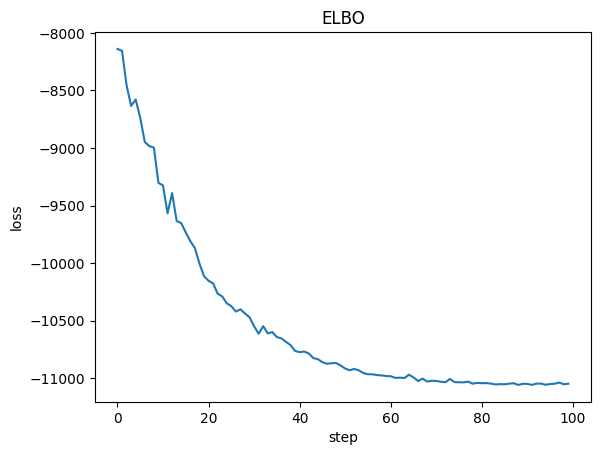

In [11]:
plot_loss(ll[0])

In [12]:
params = locate.learned_parameters_Clonal()

In [13]:
# from locate.utils import plot_purity_ploidy_hist
# draws = locate.posterior_draws(num_samples=1000, sites=["purity","ploidy"])
# plot_purity_ploidy_hist(draws)


In [14]:
purity = params['purity']
if not fix_ploidy:
    ploidy = params['ploidy']
else:
    ploidy = None
print(purity, ploidy)

[0.89979976] None


In [15]:
res_plot = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

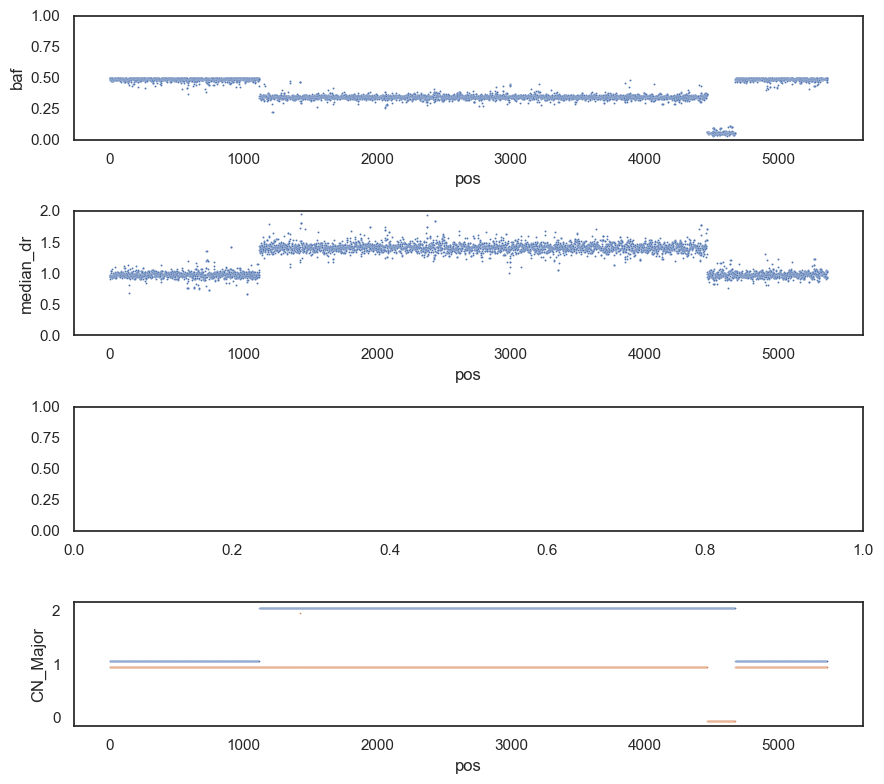

In [16]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=data, x="pos", y="baf", s=2, ax=axes[0])
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1])

cn = sns.scatterplot(data=res_plot, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res_plot, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,2) 
axes[2].set_ylim(0,1) 

fig.tight_layout()

In [17]:
res = pd.DataFrame({'CN_Major':params["CN_Major"],
                    'CN_minor':params["CN_minor"],
                    'pos':[i for i in range(len(params["CN_minor"]))]})

In [18]:
from locate.evaluation.metric import score_cn_predictions
out_df = score_cn_predictions(data, res, sample_name="sim_1")

In [22]:
out_df

{'summary':   sample  n_positions  allelic_accuracy  total_cn_accuracy  total_cn_mae  \
 0  sim_1         5365          0.998882           0.999068      0.000932   
 
    precision_totalCN_macro  recall_totalCN_macro  f1_totalCN_macro  \
 0                 0.999603              0.999155          0.999379   
 
    precision_pair_macro  recall_pair_macro  f1_pair_macro  
 0              0.998121           0.997822       0.997972  ,
 'per_class_total':    totalCN  precision    recall        F1  support
 0        2   0.999504  0.999504  0.999504     2018
 1        3   0.999701  0.998805  0.999253     3347,
 'per_class_pair':   pair  precision    recall        F1  support
 0  1:1   0.999447  0.999447  0.999447     1809
 1  2:0   0.995215  0.995215  0.995215      209
 2  2:1   0.999701  0.998805  0.999253     3347,
 'confusion_total': pred_totalCN      2     3  4
 truth_totalCN               
 2              2017     1  0
 3                 1  3343  3
 4                 0     0  0,
 'confusi